In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# import data
walcl = pd.read_csv('~/project_ascend/fred_economic/Data/WALCL_10yr.csv')
cpi = pd.read_csv('~/project_ascend/fred_economic/Data/CPIAUCSL_10yr.csv')
gdp = pd.read_csv('~/project_ascend/fred_economic/Data/GDP_10yr.csv')
unemp = pd.read_csv('~/project_ascend/fred_economic/Data/UNRATE_10yr.csv')
fedfunds = pd.read_csv('~/project_ascend/fred_economic/Data/FEDFUNDS_10yr.csv')
unrate = pd.read_csv('~/project_ascend/fred_economic/Data/UNRATE_10yr.csv')

In [3]:
# rename columns
walcl.columns = ['date', 'walcl']
cpi.columns = ['date', 'cpi']
gdp.columns = ['date', 'gdp']
unemp.columns = ['date', 'unemp']
fedfunds.columns = ['date', 'fedfunds']
unrate.columns = ['date', 'unrate']

# convert date to datetime
walcl['date'] = pd.to_datetime(walcl['date'])
cpi['date'] = pd.to_datetime(cpi['date'])
gdp['date'] = pd.to_datetime(gdp['date'])
unemp['date'] = pd.to_datetime(unemp['date'])
fedfunds['date'] = pd.to_datetime(fedfunds['date'])
unrate['date'] = pd.to_datetime(unrate['date'])

In [4]:
# Aggregate mean for each month WALCL
walcl = walcl.groupby(walcl['date'].dt.to_period('M')).mean()
walcl.reset_index(inplace=True)

# Set the index to the date column
gdp = gdp.set_index('date')

# Resample the data to the monthly frequency
gdp_monthly = gdp.asfreq('MS')

# Interpolate the monthly data using linear interpolation
gdp_monthly = gdp_monthly.interpolate(method='linear')

# Reset the index to include the date column
gdp_monthly = gdp_monthly.reset_index()



In [5]:
# Convert all date columns to YYYY-MM format
walcl['date'] = walcl['date'].dt.strftime('%Y-%m')
cpi['date'] = cpi['date'].dt.strftime('%Y-%m')
gdp_monthly['date'] = gdp_monthly['date'].dt.strftime('%Y-%m')
unemp['date'] = unemp['date'].dt.strftime('%Y-%m')
fedfunds['date'] = fedfunds['date'].dt.strftime('%Y-%m')
unrate['date'] = unrate['date'].dt.strftime('%Y-%m')


In [6]:
# merge dataframes
df = pd.merge(walcl, cpi, on='date')
df = pd.merge(df, gdp_monthly, on='date')
df = pd.merge(df, unemp, on='date')
df = pd.merge(df, fedfunds, on='date')
df = pd.merge(df, unrate, on='date')


In [7]:
df.isnull().any()

date        False
walcl       False
cpi         False
gdp         False
unemp       False
fedfunds    False
unrate      False
dtype: bool

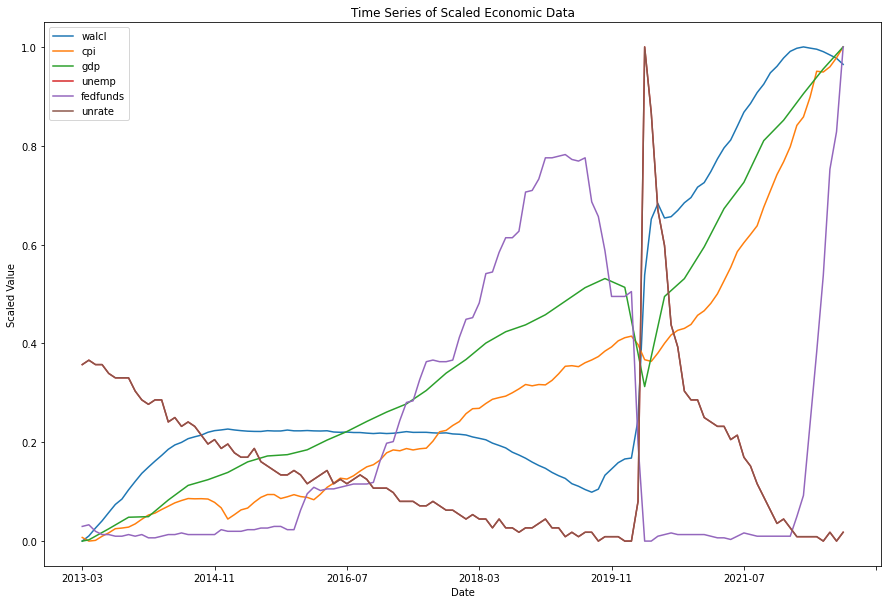

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Create scaler
scaler = MinMaxScaler()

df.set_index('date', inplace = True)

# Scale the data
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index = df.index)

# Plot the data
df_scaled.plot(figsize=(15, 10))
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Time Series of Scaled Economic Data')
plt.show()

In [9]:
# Save the scaled data to csv
df_scaled.to_csv('~/project_ascend/fred_economic/Data/scaled_data.csv')

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [11]:
# import scaled data
df_scaled = pd.read_csv('~/project_ascend/fred_economic/Data/scaled_data.csv', index_col='date', parse_dates=True)

# Set the frequency to monthly
df_scaled = df_scaled.asfreq('MS')

Test RMSE: 0.573


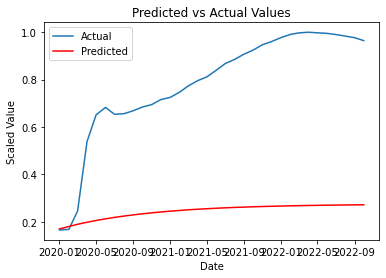

In [12]:
# Split the data into train and test sets
train = df_scaled[:'2019-12']
test = df_scaled['2020-01':]

# Define ARIMA model
model = ARIMA(train['walcl'], order=(1, 1, 1))

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Calculate the RMSE of the predictions
rmse = np.sqrt(mean_squared_error(test['walcl'], predictions))
print('Test RMSE: %.3f' % rmse)

# Plot the predicted vs actual values
plt.plot(test.index, test['walcl'], label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()

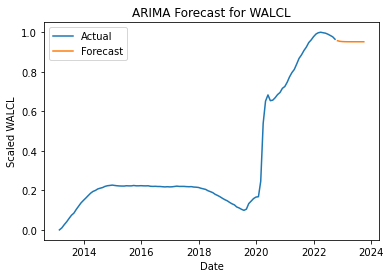

In [13]:
# Fit the ARIMA model to the scaled data
model = ARIMA(df_scaled['walcl'], order=(1,1,1))
arima_result = model.fit()

# Plot the original walcl data
plt.plot(df_scaled.index, df_scaled['walcl'], label='Actual')

# Forecast the next 12 values of walcl
n_periods = 12
forecast_result = arima_result.forecast(steps=n_periods)
forecast_index = pd.date_range(start=df_scaled.index[-1], periods=n_periods+1, freq='MS')[1:]
plt.plot(forecast_index, forecast_result, label='Forecast')

# Add title, legend, and axis labels to the plot
plt.title('ARIMA Forecast for WALCL')
plt.xlabel('Date')
plt.ylabel('Scaled WALCL')
plt.legend()

# Show the plot
plt.show()

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [15]:
df_scaled

,walcl,cpi,gdp,unemp,fedfunds,unrate
date,,,,,,
2013-03-01,0.000000,0.007327,0.000000,0.357143,0.029703,0.357143
2013-04-01,0.010386,0.000000,0.002482,0.366071,0.033003,0.366071
2013-05-01,0.026356,0.001450,0.009928,0.357143,0.019802,0.357143
2013-06-01,0.040990,0.009790,0.017374,0.357143,0.013201,0.357143
2013-07-01,0.057727,0.016664,0.024820,0.339286,0.013201,0.339286
...,...,...,...,...,...,...
2022-06-01,0.995334,0.950763,0.938799,0.008929,0.382838,0.008929
2022-07-01,0.990374,0.949252,0.955537,0.000000,0.537954,0.000000
2022-08-01,0.983756,0.959707,0.970358,0.017857,0.752475,0.017857


In [26]:
# Select the features to use for prediction
X = df_scaled[['cpi', 'gdp', 'unemp', 'fedfunds', 'unrate']]
y = df_scaled['walcl']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
# Print the RMSE of the predictions
print('RMSE:', rmse)
print('R2:', r2)

RMSE: 0.01093563530158901
R2: 0.9988604996808201
